# Transformation Equations:  DES DR2 <--> SDSS DR13

_Douglas L. Tucker_

_2020.11.19_

## Initial Setup

In [1]:
import numpy as np
import pandas as pd

import os
import sys
import glob
import math
import datetime

from collections import OrderedDict as odict

from astropy.io import fits
from astropy.table import Table

import fitsio

from scipy import interpolate
from scipy.optimize import leastsq

import healpy as hp
import healpixTools

import extinction

import paramFile

import plotly
from plotly.offline import download_plotlyjs, plot, iplot
import plotly.graph_objs as go

import matplotlib.pyplot as plt

%matplotlib inline

## Input Parameters

In [2]:
# List of bands on which to run the transform fit...
#bandList = ['g']
#bandList = ['g', 'r', 'i', 'z']
bandList = ['i', 'z']
            
# SDSS-->DES (toDES=True) or DES-->SDSS (toDES=False)...
toDES = True
#toDES = False


# Color to fit against...
#color_name_1 = 'gi'
color_name_1 = 'iz'


# Name of color_name_1 as the label in the QA plots...
#colorLabel_1 = '(g-i)'
colorLabel_1 = '(i-z)'


if toDES:
    # If SDSS-->DES, then the color to fit against and its plot label are SDSS...
    color_name_1 = """%s_sdss""" % (color_name_1)
    colorLabel_1 = """$%s_{sdss}$""" % colorLabel_1    
else:
    # If DES-->SDSS, then the color to fit against and its plot label are DES...
    color_name_1 = """%s_des""" % (color_name_1)
    colorLabel_1 = """$%s_{des}$""" % colorLabel_1    


# Order of polynomial fits...
norder = 2

# Sigma-clipping parameters...
nsigma = 3.0
niter = 3

# Identify directory containing the DES/SDSS match file...
matchDir = '.'

# Name of the DES/SDSS match file in matchDir
matchFile = 'match_y6a2_stripe82area_stars_SDSSDR13.fits'

# Base name of fit results output file...
if toDES:
    #resultsFileBaseName = 'transFit.sdss_to_des'
    resultsFileBaseName = 'transFit.sdss_to_des_iz'
else:
    #resultsFileBaseName = 'transFit.des_to_sdss'
    resultsFileBaseName = 'transFit.des_to_sdss_iz'

# Base name of QA plot output files...
if toDES:
    #qaFileBaseName = 'qaPlot.sdss_to_des.fit'
    qaFileBaseName = 'qaPlot.sdss_to_des_iz.fit'
else:
    #qaFileBaseName = 'qaPlot.des_to_sdss.fit'
    qaFileBaseName = 'qaPlot.des_to_sdss_iz.fit'

# Verbosity level (0, 1, 2, 3, ...)
verbose = 2

## Define Some Modules

In [3]:
##################################
#
# Define some functions for fitting dmag vs. color...
#
# These functions are based on a scripts found at 
# http://linuxgazette.net/115/andreasen.html (by Anders Andreasen)
# and at
# http://www.phy.uct.ac.za/courses/python/examples/fitresonance.py (University of Cape Town)


##################################

# Parametric function:  
#  p is the parameter vector; 
#  For fp1, we assume a polynomial function in one color...
def fp1(p,color1_array):
    #retValue = p[0] + p[1]*color1_array + p[2]*color1_array*color1_array
    norder = p.size-1
    retValue = p[0]
    for i in range(norder):
        retValue = retValue + p[i+1]*color1_array**(i+1)
    return retValue


##################################

# Error function:
def residuals1(p,color1_array,dmag_array):
    err = (dmag_array-fp1(p,color1_array))
    return err


##################################

# Fitting code:
def transformFit1(color1_array, dmag_array, norder=2, verbose=0):

    # Calculate the median of dmag for use as an initial guess
    # for the overall zeropoint offset..
    mdn = np.median( dmag_array, None )

    # Parameter names
    #pname = (['c_0', 'c_1', 'c_2'])
    pname = []
    for i in range(0,norder+1):
        pname.append("""c_%d""" % i)

    # Initial parameter values
    #p0 = [mdn, 0.0, 0.0]
    p0 = (1+norder)*[0.0]
    p0[0] = mdn

    if verbose > 0:
        print 
        print 'Initial parameter values:  ', p0

    # Perform fit

    p,cov,infodict,mesg,ier = leastsq(residuals1, p0, 
                                      args=(color1_array, dmag_array), 
                                      maxfev=10000, full_output=1)

    if ( ier>=1 and ier <=4):
        if verbose > 0:  print "Converged"
    else:
        # Add an exception error or a non-zero return value?
        print "Not converged"
        print mesg


    # Calculate some descriptors of the fit 
    # (similar to the output from gnuplot 2d fits)

    chisq=sum(infodict['fvec']*infodict['fvec'])
    dof=len(dmag_array)-len(p)
    rms=math.sqrt(chisq/dof)
    
    if verbose > 0:
        print "Converged with chi squared ",chisq
        print "degrees of freedom, dof ", dof
        print "RMS of residuals (i.e. sqrt(chisq/dof)) ", rms
        print "Reduced chisq (i.e. variance of residuals) ", chisq/dof
        print


    # uncertainties are calculated as per gnuplot, "fixing" the result
    # for non unit values of the reduced chisq.
    # values at min match gnuplot
    perr = []
    if verbose > 0:  
        print "Fitted parameters at minimum, with 68% C.I.:"
    for i,pmin in enumerate(p):
        if verbose > 0:  
            print "%-10s %13g +/- %13g   (%5f percent)" % (pname[i],pmin,math.sqrt(cov[i,i])*math.sqrt(chisq/dof),
                                                           100.*math.sqrt(cov[i,i])*math.sqrt(chisq/dof)/abs(pmin))
        perr.append(math.sqrt(cov[i,i])*math.sqrt(chisq/dof))
    if verbose > 0: print

    if verbose > 0:
        print "Correlation matrix:"
        # correlation matrix close to gnuplot
        print "               ",
        for i in range(len(pname)): print "%-10s" % (pname[i],),
        print
        for i in range(len(p)):
            print "%-10s" % pname[i],
            for j in range(i+1):
                print "%10f" % (cov[i,j]/math.sqrt(cov[i,i]*cov[j,j]),),
            #endfor
            print
        #endfor
        print
        print
        print
    
    return p, perr, rms


In [4]:
##################################

def createFitResultsOutputLine(norder, p, perr, rms, dmag_name, color1_name, color2_name=''):

    outputList = (2*(2*norder+1)+4)*[-9999.]
    outputList[0] = dmag_name
    outputList[1] = color1_name
    outputList[2] = color2_name
    for j in range(p.size):
        outputList[2*j+3] = p[j]
        outputList[2*j+4] = perr[j]
    outputList[2*(2*norder+1)+3] = rms
    outputLine = ','.join(map(str, outputList))
    return outputLine


##################################

def createFitResultsHeaderOutputLine(norder):

    outputList = (2*(2*norder+1)+4)*['c_']
    outputList[0] = 'dmag_name'
    outputList[1] = 'color1_name'
    outputList[2] = 'color2_name'
    for j in range(2*norder+1):
        outputList[2*j+3] = ("""c_%d""" % j)
        outputList[2*j+4] = ("""cerr_%d""" % j)
    outputList[2*(2*norder+1)+3] = 'rms'
    outputLine = ','.join(map(str, outputList))
    return outputLine


##################################

def transform1ColorQAPlots1(dmag, color1, res, norder, title, dmagName, colorLabel1, p, rms, outputFileName):

    # Prepare QA plots...
    #fig = plt.figure(figsize=(10,5))
    #fig = plt.figure(figsize=(40,20))
    fig = plt.figure(figsize=(20,10))
    fig.subplots_adjust(hspace=0.3)
    #fig.suptitle("This is a supertitle!")
    plt.rcParams.update({'font.size': 24})
    
    
    # We will exclude the lowest and highets 0.01% of color1, color2, 
    #  dmag, and residuals when plotting the QA figures...
    color1_desc = color1.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    dmag_desc = dmag.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    #res_desc = df.res.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    res_desc = res.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    #color1_min = color1_desc['1%']
    #color1_max = color1_desc['99%']
    #color1_min = color1_desc['min']
    #color1_max = color1_desc['max']
    #dmag_min = dmag_desc['1%']
    #dmag_max = dmag_desc['99%']
    #res_min = res_desc['1%']
    #res_max = res_desc['99%']
    color1_min = color1_desc['0.01%']
    color1_max = color1_desc['99.99%']
    dmag_min = dmag_desc['0.01%']
    dmag_max = dmag_desc['99.99%']
    res_min = res_desc['0.01%']
    res_max = res_desc['99.99%']


    # Plot 1:  Descriptive text...
    #plt.subplot(231)
    plt.subplot(221)
    if norder == 1:
        plot1Text = """%s \n\n%s = \n %.3f + \n %.3f*%s \n\n [rms: %.3f] \n\n [%.1f < %s < %.1f]""" % \
            (title, dmagName, p[0], p[1], colorLabel1, rms, color1_desc['min'], colorLabel1, color1_desc['max'])
    elif norder == 2:
        plot1Text = """%s \n\n%s = \n %.3f + \n %.3f*%s + \n %.3f*%s^2 \n\n [rms: %.3f] \n\n [%.1f < %s < %.1f]""" % \
            (title, dmagName, p[0], p[1], colorLabel1, p[2], colorLabel1, rms, color1_desc['min'], colorLabel1, color1_desc['max'])
    else:
        plot1Text = ''
    #plt.text(0.1,0.25,plot1Text)
    plt.text(0.1,0.00,plot1Text)
    plt.axis('off')

    
    # Plot 2:  2D hexbin histogram of dmag vs. color1...
    #plt.subplot(232) 
    plt.subplot(222)
    hb=plt.hexbin(color1, dmag, gridsize=100, bins='log', cmap='inferno')
    plt.axis([color1_min, color1_max, dmag_min, dmag_max])
    plt.xlabel(colorLabel1)
    plt.ylabel(dmagName)
    cb = fig.colorbar(hb)
    #cb.set_label('Number')
    cb.set_label('log10(N)')
    plt.grid(color='white')
    plt.grid(True)

    
    # Plot 3:  1d histogram of residuals...
    #plt.subplot(234) 
    plt.subplot(223) 
    #plt.hist(df.loc[:,'res'],bins=100)
    plt.hist(res,bins=100)
    plt.xlabel('residuals [mag]')
    plt.ylabel('Number')
    plt.grid(True)
    plt.grid(color='black')

    
    # Plot 4:  2d hexbin histogram of residuals vs. color1...
    #plt.subplot(235) 
    plt.subplot(224) 
    #hb = plt.hexbin(color1, df.loc[:,'res'], gridsize=100, cmap='inferno')
    hb = plt.hexbin(color1, res, gridsize=100, bins='log', cmap='inferno')
    plt.axis([color1_min, color1_max, res_min, res_max])
    plt.xlabel(colorLabel1)
    plt.ylabel('residuals [mag]')
    cb = plt.colorbar(hb)
    #cb.set_label('Number')
    cb.set_label('log10(N)')
    plt.grid(True)
    plt.grid(color='white')


    # Plot...
    plt.tight_layout()
    #plt.show()
    plt.savefig(outputFileName)

    return 0


##################################


## Read in Matched Catalog

In [5]:
matchFile = os.path.join(matchDir,matchFile)
print matchFile

./match_y6a2_stripe82area_stars_SDSSDR13.fits


In [6]:
# Check to make sure matchFile exists...
if os.path.isfile(matchFile)==False:
    print """ERROR:  matchFile %s does not exist...""" % (matchFile)
if verbose > 0:
    print 'matchFile: ', matchFile


matchFile:  ./match_y6a2_stripe82area_stars_SDSSDR13.fits


In [7]:
tab = Table.read(matchFile, format='fits')
tab

COADD_OBJECT_ID,RA_1,DEC_1,ALPHAWIN_J2000,DELTAWIN_J2000,PFW_ATTEMPT_ID,OBJECT_NUMBER,PARENT_NUMBER,TILENAME,L,B,EBV_SFD98,HPIX_32,HPIX_64,HPIX_1024,HPIX_4096,HPIX_16384,KRON_RADIUS,A_IMAGE,B_IMAGE,THETA_J2000,ERRA_IMAGE,ERRB_IMAGE,ERRTHETA_IMAGE,XWIN_IMAGE,YWIN_IMAGE,MAG_DETMODEL_G,MAG_AUTO_G,MAG_APER_8_G,WAVG_MAG_PSF_G,MAGERR_DETMODEL_G,MAGERR_AUTO_G,MAGERR_APER_8_G,WAVG_MAGERR_PSF_G,FLUX_DETMODEL_G,FLUX_AUTO_G,WAVG_FLUX_PSF_G,FLUX_RADIUS_G,FLUX_APER_8_G,FLUXERR_DETMODEL_G,FLUXERR_AUTO_G,WAVG_FLUXERR_PSF_G,FLUXERR_APER_8_G,MU_EFF_MODEL_G,MU_MAX_G,MU_MAX_MODEL_G,MU_MEAN_MODEL_G,MU_THRESHOLD_G,SPREADERR_MODEL_G,SPREAD_MODEL_G,CLASS_STAR_G,NITER_MODEL_G,WAVG_SPREADERR_MODEL_G,WAVG_SPREAD_MODEL_G,FLAGS_G,IMAFLAGS_ISO_G,NEPOCHS_G,MOLY_NUMBER_G,MAG_DETMODEL_R,MAG_AUTO_R,MAG_APER_8_R,WAVG_MAG_PSF_R,MAGERR_DETMODEL_R,MAGERR_AUTO_R,MAGERR_APER_8_R,WAVG_MAGERR_PSF_R,FLUX_DETMODEL_R,FLUX_AUTO_R,WAVG_FLUX_PSF_R,FLUX_RADIUS_R,FLUX_APER_8_R,FLUXERR_DETMODEL_R,FLUXERR_AUTO_R,WAVG_FLUXERR_PSF_R,FLUXERR_APER_8_R,MU_EFF_MODEL_R,MU_MAX_R,MU_MAX_MODEL_R,MU_MEAN_MODEL_R,MU_THRESHOLD_R,SPREADERR_MODEL_R,SPREAD_MODEL_R,CLASS_STAR_R,NITER_MODEL_R,WAVG_SPREADERR_MODEL_R,WAVG_SPREAD_MODEL_R,FLAGS_R,IMAFLAGS_ISO_R,NEPOCHS_R,MOLY_NUMBER_R,MAG_DETMODEL_I,MAG_AUTO_I,MAG_APER_8_I,WAVG_MAG_PSF_I,MAGERR_DETMODEL_I,MAGERR_AUTO_I,MAGERR_APER_8_I,WAVG_MAGERR_PSF_I,FLUX_DETMODEL_I,FLUX_AUTO_I,WAVG_FLUX_PSF_I,FLUX_RADIUS_I,FLUX_APER_8_I,FLUXERR_DETMODEL_I,FLUXERR_AUTO_I,WAVG_FLUXERR_PSF_I,FLUXERR_APER_8_I,MU_EFF_MODEL_I,MU_MAX_I,MU_MAX_MODEL_I,MU_MEAN_MODEL_I,MU_THRESHOLD_I,SPREADERR_MODEL_I,SPREAD_MODEL_I,CLASS_STAR_I,NITER_MODEL_I,WAVG_SPREADERR_MODEL_I,WAVG_SPREAD_MODEL_I,FLAGS_I,IMAFLAGS_ISO_I,NEPOCHS_I,MOLY_NUMBER_I,MAG_DETMODEL_Z,MAG_AUTO_Z,MAG_APER_8_Z,WAVG_MAG_PSF_Z,MAGERR_DETMODEL_Z,MAGERR_AUTO_Z,MAGERR_APER_8_Z,WAVG_MAGERR_PSF_Z,FLUX_DETMODEL_Z,FLUX_AUTO_Z,WAVG_FLUX_PSF_Z,FLUX_RADIUS_Z,FLUX_APER_8_Z,FLUXERR_DETMODEL_Z,FLUXERR_AUTO_Z,WAVG_FLUXERR_PSF_Z,FLUXERR_APER_8_Z,MU_EFF_MODEL_Z,MU_MAX_Z,MU_MAX_MODEL_Z,MU_MEAN_MODEL_Z,MU_THRESHOLD_Z,SPREADERR_MODEL_Z,SPREAD_MODEL_Z,CLASS_STAR_Z,NITER_MODEL_Z,WAVG_SPREADERR_MODEL_Z,WAVG_SPREAD_MODEL_Z,FLAGS_Z,IMAFLAGS_ISO_Z,NEPOCHS_Z,MOLY_NUMBER_Z,MAG_DETMODEL_Y,MAG_AUTO_Y,MAG_APER_8_Y,WAVG_MAG_PSF_Y,MAGERR_DETMODEL_Y,MAGERR_AUTO_Y,MAGERR_APER_8_Y,WAVG_MAGERR_PSF_Y,FLUX_DETMODEL_Y,FLUX_AUTO_Y,WAVG_FLUX_PSF_Y,FLUX_RADIUS_Y,FLUX_APER_8_Y,FLUXERR_DETMODEL_Y,FLUXERR_AUTO_Y,WAVG_FLUXERR_PSF_Y,FLUXERR_APER_8_Y,MU_EFF_MODEL_Y,MU_MAX_Y,MU_MAX_MODEL_Y,MU_MEAN_MODEL_Y,MU_THRESHOLD_Y,SPREADERR_MODEL_Y,SPREAD_MODEL_Y,CLASS_STAR_Y,NITER_MODEL_Y,WAVG_SPREADERR_MODEL_Y,WAVG_SPREAD_MODEL_Y,FLAGS_Y,IMAFLAGS_ISO_Y,NEPOCHS_Y,MOLY_NUMBER_Y,rawrap,name,ra_2,dec_2,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,psfMagErr_u,psfMagErr_g,psfMagErr_r,psfMagErr_i,psfMagErr_z,run,stripe,Separation
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,,,,,,,,,,,arcsec
int64,float64,float64,float64,float64,int64,int32,int32,str48,float64,float64,float64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,int16,int32,int32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,int16,int32,int32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,int16,int32,int32,int64,float64,float64,float64,float64,f

In [8]:
df = tab.to_pandas()
df

,COADD_OBJECT_ID,RA_1,DEC_1,ALPHAWIN_J2000,DELTAWIN_J2000,PFW_ATTEMPT_ID,OBJECT_NUMBER,PARENT_NUMBER,TILENAME,L,...,psfMag_i,psfMag_z,psfMagErr_u,psfMagErr_g,psfMagErr_r,psfMagErr_i,psfMagErr_z,run,stripe,Separation
0,1.033597e+09,0.000058,-2.417387,0.000058,-2.417387,2758897.0,7033.0,7252.0,DES0000-0207,94.259300,...,18.352320,18.197308,0.105668,0.017967,0.016583,0.023540,0.027509,6361.0,1188.0,0.072306
1,1.032384e+09,0.000101,-2.967177,0.000101,-2.967177,2764753.0,20554.0,22091.0,DES0000-0250,93.743797,...,17.273417,16.676876,0.189597,0.026167,0.015462,0.021712,0.017184,7778.0,83.0,0.131657
2,1.032146e+09,0.000110,3.352002,0.000110,3.352002,2763748.0,10494.0,11267.0,DES0000+0335,98.794853,...,16.957182,16.818913,0.028147,0.018261,0.025981,0.018688,0.016255,7717.0,81.0,0.081412
3,1.034107e+09,0.000249,-0.838739,0.000249,-0.838739,2764748.0,20138.0,22019.0,DES2359-0041,95.649406,...,18.321367,18.298330,0.039136,0.023591,0.014854,0.019058,0.027282,4263.0,82.0,0.147025
4,1.034254e+09,0.000297,-1.034322,0.000297,-1.034322,2764748.0,3080.0,2902.0,DES2359-0041,95.484200,...,16.302778,16.103003,0.041825,0.020095,0.013199,0.018106,0.014031,2662.0,82.0,0.153573
5,1.034175e+09,0.000446,-4.093737,0.000446,-4.093737,2765741.0,54158.0,57212.0,DES0000-0416,92.631699,...,16.801933,16.655245,0.036887,0.025139,0.016387,0.013504,0.019310,6372.0,1188.0,0.167864
6,1.033052e+09,0.000603,2.368938,0.000603,2.368938,2763744.0,59148.0,63542.0,DES0000+0209,98.119377,...,18.253973,17.978533,0.194086,0.022775,0.022852,0.024477,0.028400,7712.0,81.0,0.101826
7,1.032398e+09,0.000712,-3.137557,0.000712,-3.137557,2764753.0,6582.0,6535.0,DES0000-0250,93.581673,...,16.352743,15.775401,0.155956,0.028578,0.017661,0.022097,0.017449,7907.0,83.0,0.166721
8,1.031851e+09,0.000722,-1.804559,0.000722,-1.804559,2758897.0,63615.0,68635.0,DES0000-0207,94.815483,...,17.041483,16.389420,0.193003,0.025014,0.022046,0.017063,0.015475,7778.0,83.0,0.254651
9,1.032029e+09,0.000793,3.106721,0.000793,3.106721,2763746.0,52903.0,57019.0,DES0000+0252,98.630432,...,17.687784,17.438276,0.096128,0.020033,0.014446,0.011822,0.017752,7717.0,81.0,0.093407


In [9]:
# Rename columns...
df.rename(columns={'RA_1':'RA_des',
                   'DEC_1':'DEC_des',
                   'ra_2':'RA_sdss',
                   'dec_2':'DEC_sdss',
                   'WAVG_MAG_PSF_G':'g_des',
                   'WAVG_MAG_PSF_R':'r_des',
                   'WAVG_MAG_PSF_I':'i_des',
                   'WAVG_MAG_PSF_Z':'z_des',
                   'WAVG_MAG_PSF_Y':'Y_des',
                   'WAVG_MAGERR_PSF_G':'g_err_des',
                   'WAVG_MAGERR_PSF_R':'r_err_des',
                   'WAVG_MAGERR_PSF_I':'i_err_des',
                   'WAVG_MAGERR_PSF_Z':'z_err_des',
                   'WAVG_MAGERR_PSF_Y':'Y_err_des',
                   'psfMag_u':'u_sdss',
                   'psfMag_g':'g_sdss',
                   'psfMag_r':'r_sdss',
                   'psfMag_i':'i_sdss',
                   'psfMag_z':'z_sdss',
                   'psfMagErr_u':'u_err_sdss',
                   'psfMagErr_g':'g_err_sdss',
                   'psfMagErr_r':'r_err_sdss',
                   'psfMagErr_i':'i_err_sdss',
                   'psfMagErr_z':'z_err_sdss',
                  },inplace=True)

df.head(5)

,COADD_OBJECT_ID,RA_des,DEC_des,ALPHAWIN_J2000,DELTAWIN_J2000,PFW_ATTEMPT_ID,OBJECT_NUMBER,PARENT_NUMBER,TILENAME,L,...,i_sdss,z_sdss,u_err_sdss,g_err_sdss,r_err_sdss,i_err_sdss,z_err_sdss,run,stripe,Separation
0,1.033597e+09,0.000058,-2.417387,0.000058,-2.417387,2758897.0,7033.0,7252.0,DES0000-0207,94.259300,...,18.352320,18.197308,0.105668,0.017967,0.016583,0.023540,0.027509,6361.0,1188.0,0.072306
1,1.032384e+09,0.000101,-2.967177,0.000101,-2.967177,2764753.0,20554.0,22091.0,DES0000-0250,93.743797,...,17.273417,16.676876,0.189597,0.026167,0.015462,0.021712,0.017184,7778.0,83.0,0.131657
2,1.032146e+09,0.000110,3.352002,0.000110,3.352002,2763748.0,10494.0,11267.0,DES0000+0335,98.794853,...,16.957182,16.818913,0.028147,0.018261,0.025981,0.018688,0.016255,7717.0,81.0,0.081412
3,1.034107e+09,0.000249,-0.838739,0.000249,-0.838739,2764748.0,20138.0,22019.0,DES2359-0041,95.649406,...,18.321367,18.298330,0.039136,0.023591,0.014854,0.019058,0.027282,4263.0,82.0,0.147025
4,1.034254e+09,0.000297,-1.034322,0.000297,-1.034322,2764748.0,3080.0,2902.0,DES2359-0041,95.484200,...,16.302778,16.103003,0.041825,0.020095,0.013199,0.018106,0.014031,2662.0,82.0,0.153573


## Add Columns to Matched Catalog Data Frame

In [10]:
# Add color columns...
df.loc[:,'gr_des'] = df.loc[:,'g_des'] - df.loc[:,'r_des']
df.loc[:,'ri_des'] = df.loc[:,'r_des'] - df.loc[:,'i_des']
df.loc[:,'iz_des'] = df.loc[:,'i_des'] - df.loc[:,'z_des']
df.loc[:,'zY_des'] = df.loc[:,'z_des'] - df.loc[:,'Y_des']
df.loc[:,'gi_des'] = df.loc[:,'g_des'] - df.loc[:,'i_des']

df.loc[:,'ug_sdss'] = df.loc[:,'u_sdss'] - df.loc[:,'g_sdss']
df.loc[:,'gr_sdss'] = df.loc[:,'g_sdss'] - df.loc[:,'r_sdss']
df.loc[:,'ri_sdss'] = df.loc[:,'r_sdss'] - df.loc[:,'i_sdss']
df.loc[:,'iz_sdss'] = df.loc[:,'i_sdss'] - df.loc[:,'z_sdss']
df.loc[:,'gi_sdss'] = df.loc[:,'g_sdss'] - df.loc[:,'i_sdss']

In [11]:
# Insert dmag column...
df.loc[:,'dmag'] = -9999.

## Create Initial Mask

In [12]:
mask = ( ( df[color_name_1] > -1. ) & ( df[color_name_1] < 4.0 ) )

## Make Backup Copies of Initial Mask and Original Data Frame

In [13]:
# Make a backup copy of original df...
df_orig = df.copy()

# Make a backup copy of original mask...
mask_orig = mask.copy()

## Run Fit in Each Filter Band




# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
i
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

   iter1...

Initial parameter values:   [-0.013010025024414062, 0.0, 0.0]
Converged
Converged with chi squared  248.40999867625496
degrees of freedom, dof  358614
RMS of residuals (i.e. sqrt(chisq/dof))  0.026319092851
Reduced chisq (i.e. variance of residuals)  0.0006926946484974233

Fitted parameters at minimum, with 68% C.I.:
c_0            0.0242101 +/-   9.37971e-05   (0.387429 percent)
c_1            -0.243349 +/-   0.000787841   (0.323749 percent)
c_2           -0.0836999 +/-    0.00124408   (1.486362 percent)

Correlation matrix:
                c_0        c_1        c_2       
c_0          1.000000
c_1         -0.839003   1.000000
c_2          0.679841  -0.930808   1.000000



   iter2...

Initial parameter values:   [-0.013012886047363281, 0.0, 0.0]
Converged
Converged with chi squared  80.64495646021875
degrees of fr

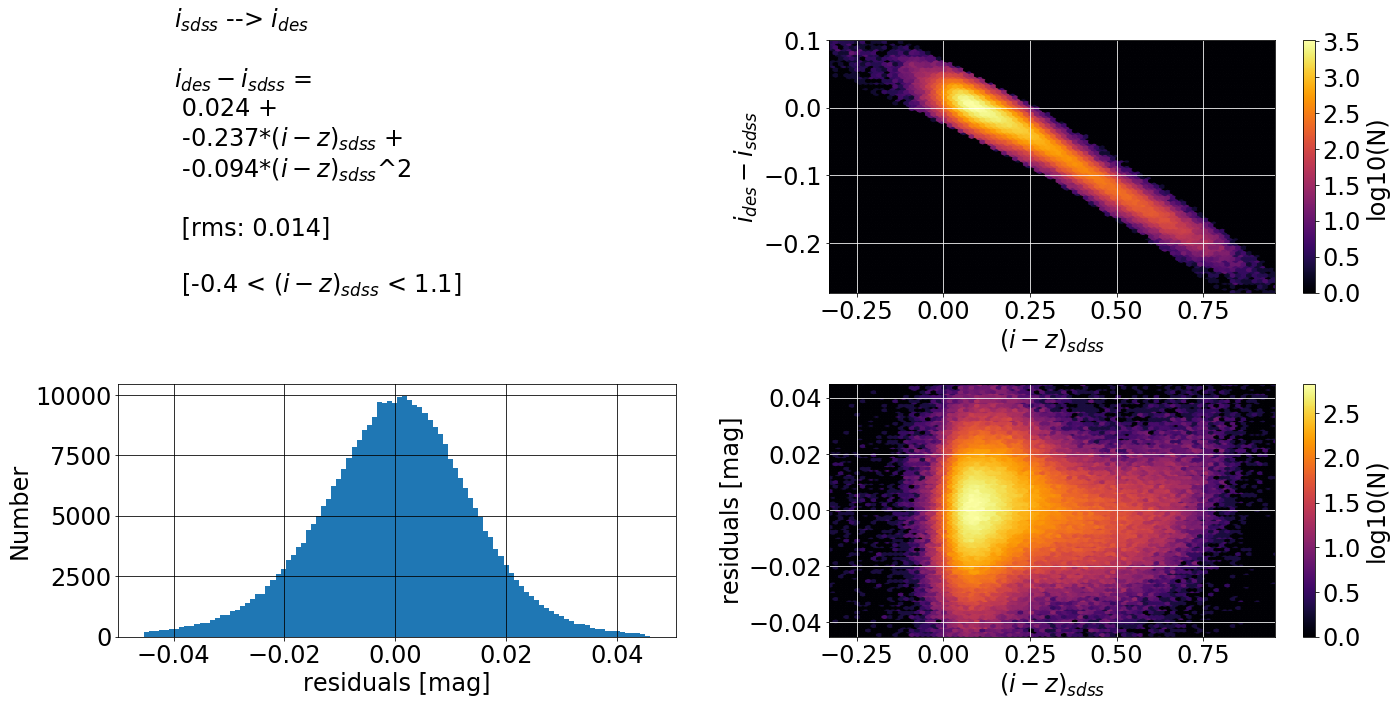

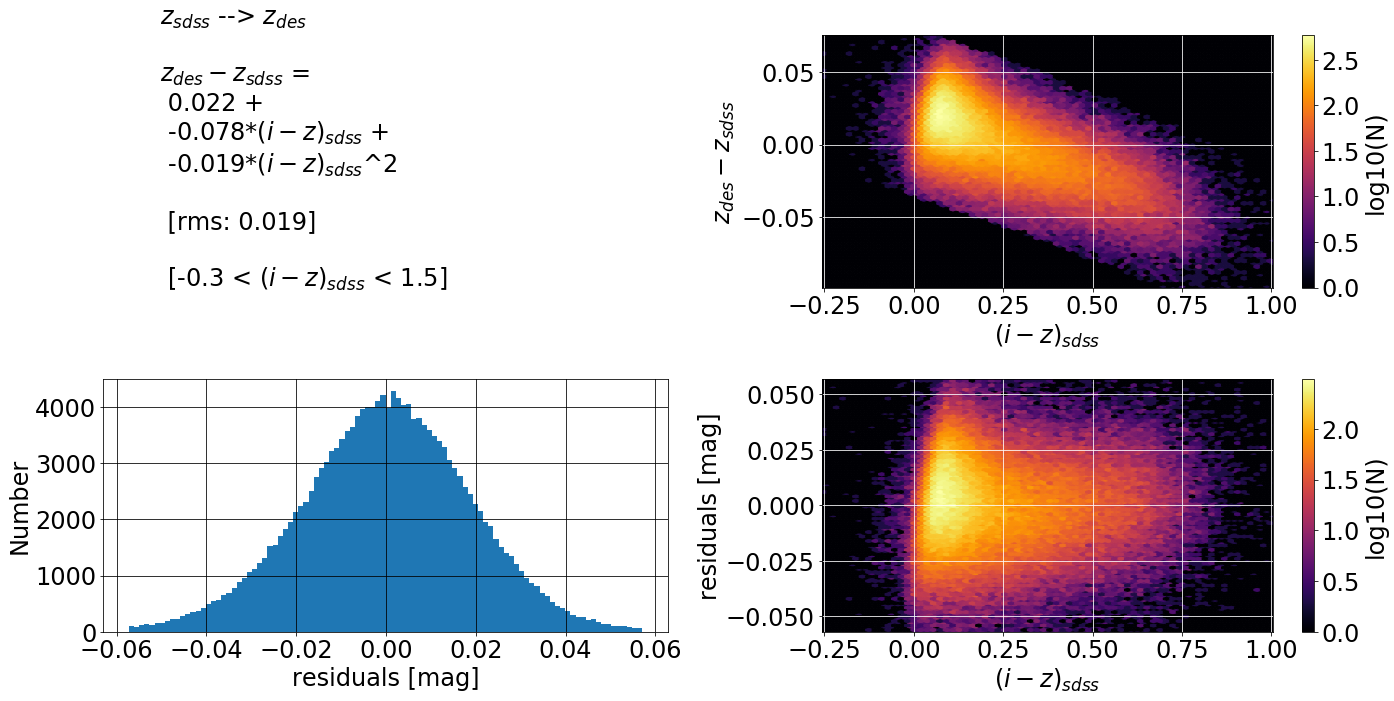

In [14]:
# Create results output file...
resultsFile = """%s.dmag.%s.norder%d.csv""" % (resultsFileBaseName, color_name_1, norder)

# Open fit results output file...
try:
    fout = open(resultsFile, 'w')
except IOError:
    sys.exit('Unable to write to file ' + resultsFile)

# Write header to fit results output file...
hdr = createFitResultsHeaderOutputLine(norder)
fout.write(hdr+'\n')

for band in bandList:
    
    print 
    print 
    print 
    print "# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # "
    print band
    print "# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # "
    print 
    
    magName_des = """%s_des""" % (band)
    magErrName_des = """%s_err_des""" % (band)
    magName_sdss = """%s_sdss""" % (band)
    magErrName_sdss = """%s_err_sdss""" % (band)
    
    # Grab the original version of df from the backup copy...
    df = df_orig.copy()

    # Grab the original version of mask from the backup copy...
    mask = mask_orig.copy()

    # Update dmag column for {$band}_des - {$band}_sdss...
    if toDES:
        df.loc[:,'dmag'] = df.loc[:,magName_des] - df.loc[:,magName_sdss]
    else:
        df.loc[:,'dmag'] = df.loc[:,magName_sdss] - df.loc[:,magName_des]

    # Update mask...
    mask1 = abs(df['dmag']) <= 10.
    mask2 = abs(df[magErrName_des]) <= 0.01
    mask3 = abs(df[magErrName_sdss]) <= 0.02
    mask = mask & mask1 & mask2 & mask3

    # Iterate, with sigma-clipping...
    for i in range(niter):

        iiter = i + 1
        if verbose > 0:
            print """   iter%d...""" % ( iiter )

        # make a copy of original df, overwriting the old one...
        df = df[mask].copy()

        # Identify dmag and color1 series...
        dmag =  df.loc[:,'dmag']
        color1 = df.loc[:,color_name_1]

        # Perform fit...
        p,perr,rms = transformFit1(color1, dmag, norder, verbose)
        df.loc[:,'res'] = residuals1(p, color1, dmag)

        # Identify outliers...|
        stddev = df['res'].std()
        mask = (np.abs(df.res)< nsigma*stddev)


    # Output results to the results file...
    outputLine = createFitResultsOutputLine(2, p, perr, rms, band, color_name_1)
    fout.write(outputLine+'\n')
    
    # Create title/names for use in QA plots...
    if toDES:
        title = """$%s_{sdss}$ --> $%s_{des}$""" % (band, band)
        dmagName = """$%s_{des} - %s_{sdss}$""" % (band, band)
    else:
        title = """$%s_{des}$ --> $%s_{sdss}$""" % (band, band)
        dmagName = """$%s_{sdss} - %s_{des}$""" % (band, band)
        
    # Create QA plots...
    res =  df.loc[:,'res']
    outputFileName = """%s.dmag_%s.%s.norder%d.qa1.png""" % (qaFileBaseName, band, color_name_1, norder)
    status = transform1ColorQAPlots1(dmag, color1, res, norder, title, dmagName, colorLabel_1, p, rms, outputFileName)

fout.close()

In [15]:
#%ls -FlthrG

In [16]:
#%less transFit.ps1_to_des.dmag.gi_ps1.norder2.csv

In [17]:
# SDSS-->DES:
# g vs. g-i (norder=1)
# r vs. r-i (norder=1)
# i vs. r-i (norder-1)
# z vs. r-i (norder=1)

In [18]:
# DES-->SDSS:
# g vs. g-i (norder=1)
# r vs. r-i (norder=1)
# i vs. r-i (norder-1)
# z vs. r-i (norder=1)

In [19]:
%pwd

u'/data/des81.b/data/dtucker/TransformEqns/DES_DR2'

In [20]:
%ls -FlthrG

total 12G
-rwxr-xr-x 1 dtucker   45K Jun 13  2018 sdss_des_transform.py*
-rw-rw-r-- 1 dtucker 1023M Nov 17  2020 y6a2_stripe82area_stars_000001.fits
-rw-rw-r-- 1 dtucker 1023M Nov 17  2020 y6a2_stripe82area_stars_000002.fits
-rw-rw-r-- 1 dtucker  204M Nov 17  2020 y6a2_stripe82area_stars_000003.fits
-rw-rw-r-- 1 dtucker   275 Nov 17  2020 y6a2_stripe82area_stars.sql
-rw-rw-r-- 1 dtucker  2.2G Nov 17  2020 y6a2_stripe82area_stars.fits
-rw-rw-r-- 1 dtucker  872M Nov 17  2020 match_y6a2_stripe82area_stars_SDSSDR13.fits
-rw-rw-r-- 1 dtucker  2.0G Nov 17  2020 match_y6a2_stripe82area_stars_PS1DR2.fits
-rw-rw-r-- 1 dtucker  2.5M Nov 18  2020 temp.csv
-rw-rw-r-- 1 dtucker  620K Nov 19  2020 TransformationEquations_DES_DR2_SDSS_DR13_orig.ipynb
-rw-rw-r-- 1 dtucker   83K Nov 20  2020 plot.uNUV.NUVg.qa1.png
-rw-rw-r-- 1 dtucker   83K Nov 20  2020 qaPlot.ps1_to_des.dmag_g.$(g-i)_{ps1}$.qa1.png
-rw-rw-r-- 1 dtucker   83K Nov 20  2020 qaPlot.ps1_to_des.dmag_g.gi_ps1.qa1.png
-rw-rw-r-- 1 dtucker   8